In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def Rastrigin_function(
    x: np.array,
    n: int = 2,
    A: float = 10,
) -> np.array:

    y = A * n + x[0]**2 - A * np.cos(2 * np.pi * x[0]) + x[1]**2 - A * np.cos(2 * np.pi * x[1]) 
    return y

def Rastrigin_gradient(
    x: np.array,
    n: int = 2,
    A: float = 10,
) -> np.array:
    
    df_dx = 2 * x[0] + 2 * np.pi * A * np.sin(2 * np.pi * x[0])
    df_dy = 2 * x[1] + 2 * np.pi * A * np.sin(2 * np.pi * x[1])
    return np.array([df_dx, df_dy])

In [85]:
def Rosenbrock_function(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:

    y = (a - x[0])**2 + b * (x[1] - x[0]**2)**2
    return y

def Rosenbrock_gradient(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    
    df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
    df_dy = 2 * b * (x[1] - x[0]**2)
    return np.array([df_dx, df_dy])

In [86]:
def sphere_function(
    x: np.array,
    A: float = 1,
    B: float = 1,
) -> np.array:

    y = A * x[0]**2 + B * x[1]**2
    return y

def sphere_gradient(
    x: np.array,
    A: float = 1,
    B: float = 1,
) -> np.array:
    
    df_dx = 2 * A * x[0]
    df_dy = 2 * B * x[1]
    return np.array([df_dx, df_dy])

In [139]:
def solution_visualization(
    function: callable,
    x_seq: list = None,
    x_star: np.array = None,
    xlim: tuple = (-5, 5),
    ylim: tuple = (-5, 5),
    step: float = 0.05,
    flat: bool = True,
    label: str = '',
    cmap: str = 'viridis'
):

    x1 = np.arange(xlim[0], xlim[1], step)
    x2 = np.arange(ylim[0], ylim[1], step)
    x = np.meshgrid(x1, x2)

    y = function(x)


    if flat:
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(10)

        im = ax.imshow(y, extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
           origin='lower', cmap=cmap, aspect='equal')
        
        fig.colorbar(im, ax=ax, shrink=0.5, aspect=5)

        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])

        if x_seq is not None:
            ax.scatter(x_seq[:, 0], x_seq[:, 1], s=3)
            ax.plot(x_seq[:, 0], x_seq[:, 1], label=label)
            ax.scatter(x_seq[-1, 0], x_seq[-1, 1], marker=(5, 1))

        if x_star is not None:
            ax.scatter(x_star[0], x_star[1], marker=(5, 1), c='r')

        plt.legend()

    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        surf = ax.plot_surface(
            x[0], x[1], y,
            facecolors=plt.cm.viridis(y), 
            rstride=1, cstride=1
        )

        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        plt.show()

In [140]:
class GradientOptimizer:
    def __init__(
        self,
        function: callable,
        grad_function: callable = None,
        method: str = 'gd',
        grad_calculation: str = '',
        stop_criteria: str = 'point_norm',
        max_iteration: int = 100,
        alpha: float = 1e-4,
        beta_1: float = 0.9,
        beta_2: float = 0.99,
        eps: float = 1e-8,
        eps_stop: float = 1e-2,
    ):

        self.function = function
        self.grad_function = grad_function
        self.method = method
        self.grad_calculation = grad_calculation
        self.stop_criteria = stop_criteria
        self.max_iteration = max_iteration
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.eps_stop = eps_stop

    def step(self):

        if self.method == 'GD':
            grad = self.grad_function(self.point_seq[-1])
            next_point = self.point_seq[-1] - self.alpha * grad

        if self.method == 'Momentum':
            grad = self.grad_function(self.point_seq[-1])
            if len(self.point_seq) > 1:
                next_point = (self.point_seq[-1] - self.alpha * grad + 
                    self.beta_1 * (self.point_seq[-1] - self.point_seq[-2]))
            else:
                next_point = self.point_seq[-1] - self.alpha * grad

        if self.method == 'NesterovMomentum':
            if len(self.point_seq) > 1:
                grad = self.grad_function(self.point_seq[-1] + self.beta_1 * self.curr_momentum)
                self.curr_momentum = self.beta_1 * self.curr_momentum - self.alpha * grad
            else:
                grad = self.grad_function(self.point_seq[-1])
                self.curr_momentum = -self.alpha * grad

            next_point = self.point_seq[-1] + self.curr_momentum

        if self.method == 'RMSProp':
            grad = self.grad_function(self.point_seq[-1])
            if len(self.point_seq) > 1:
                self.curr_adaptation = (self.beta_2 * self.curr_adaptation + 
                    (1 - self.beta_2) * grad**2)
                next_point = (self.point_seq[-1] - self.alpha * grad / 
                    np.sqrt(self.curr_adaptation + self.eps))
            else:
                self.curr_adaptation = 0
                next_point = self.point_seq[-1] - self.alpha * grad

        if self.method == 'Adam':
            grad = self.grad_function(self.point_seq[-1])
            if len(self.point_seq) > 1:
                self.curr_momentum = (self.beta_1 * self.curr_momentum +
                    (1 - self.beta_1) * grad)
                self.curr_adaptation = (self.beta_2 * self.curr_adaptation + 
                    (1 - self.beta_2) * grad**2)
                next_point = (self.point_seq[-1] - self.alpha * self.curr_momentum / 
                    np.sqrt(self.curr_adaptation + self.eps))
            else:
                self.curr_adaptation = 0
                self.curr_momentum = -self.alpha * grad
                next_point = self.point_seq[-1] - self.alpha * grad

        next_value = self.function(next_point)

        if self.stop_criteria == 'point_norm':
            done = np.linalg.norm(self.point_seq[-1] - next_point) < self.eps

        return next_point, next_value, done


    def find_minimum(self, initial_point):
        if self.grad_function is None:
            pass

        self.point_seq = []
        self.value_seq = []
        self.point_seq.append(initial_point)
        self.value_seq.append(self.function(initial_point))

        for _ in range(self.max_iteration):
            next_point, next_value, done = self.step()
            self.point_seq.append(next_point)
            self.value_seq.append(next_value)
            if done:
                break

        return np.array(self.point_seq), np.array(self.value_seq)

(101, 2)
[-0.55487497  1.94495135]
270.4158543848788


C:\Users\name\AppData\Local\Temp\ipykernel_15264\1550311567.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


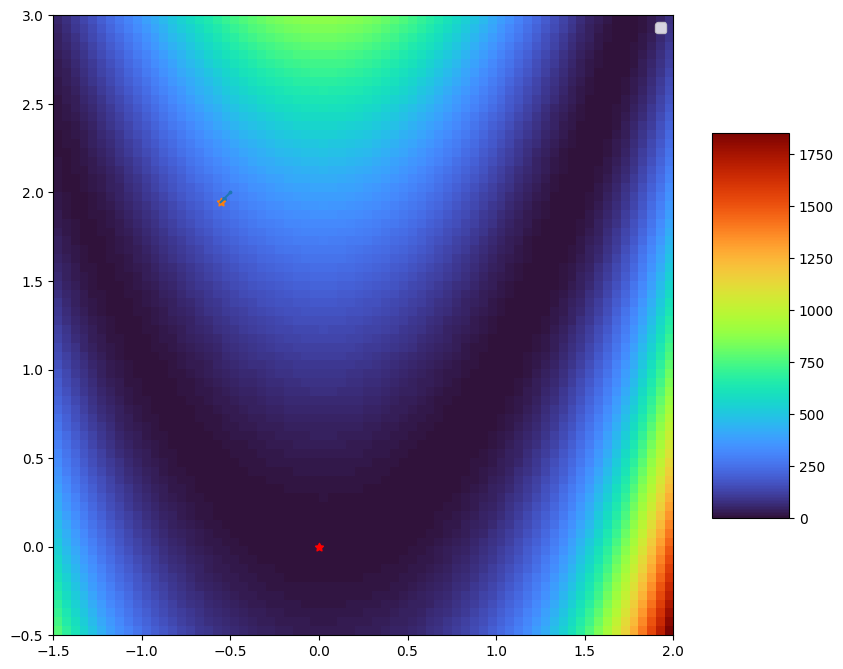

In [141]:
optimizer = GradientOptimizer(Rosenbrock_function, Rosenbrock_gradient, method='RMSProp')

x_0 = np.array([-0.5, 2])
x_seq, y_seq = optimizer.find_minimum(x_0)
print(x_seq.shape)

x_star = np.array([0, 0])
xlim = (-1.5, 2)
ylim = (-0.5, 3)
solution_visualization(Rosenbrock_function, x_seq, x_star, xlim, ylim, cmap='turbo')
print(x_seq[-1,:])
print(y_seq[-1])

In [144]:
def hyperparameter_optimization():
    x_0 = np.array([-0.5, 2])

    alphas = np.geomspace(1, 1e-4, 10)

    min_value = +np.inf

    for alpha in tqdm(alphas):
        optimizer = GradientOptimizer(
            Rosenbrock_function, 
            Rosenbrock_gradient, 
            alpha=alpha,
            method='NesterovMomentum')

        x_seq, y_seq = optimizer.find_minimum(x_0)
        if y_seq[-1] < min_value:
            best_alpha = alpha
            min_value = y_seq[-1]

    return best_alpha

In [147]:
def plot_best_solution():
    best_alpha = hyperparameter_optimization()

    optimizer = GradientOptimizer(
        Rosenbrock_function, 
        Rosenbrock_gradient, 
        method='NesterovMomentum',
        alpha=best_alpha,
        max_iteration=100,
    )

    x_0 = np.array([-0.5, 2])
    x_seq, y_seq = optimizer.find_minimum(x_0)
    print(x_seq.shape)

    x_star = np.array([0, 0])
    xlim = (-1.5, 2)
    ylim = (-0.5, 3)
    solution_visualization(Rosenbrock_function, x_seq, x_star, xlim, ylim, cmap='turbo')
    print(x_seq[-1,:])
    print(y_seq[-1])

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\name\AppData\Local\Temp\ipykernel_15264\2050498241.py:7: RuntimeWarning: overflow encountered in scalar power
  y = (a - x[0])**2 + b * (x[1] - x[0]**2)**2
C:\Users\name\AppData\Local\Temp\ipykernel_15264\2050498241.py:16: RuntimeWarning: overflow encountered in scalar multiply
  df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
C:\Users\name\AppData\Local\Temp\ipykernel_15264\1816730352.py:46: RuntimeWarning: invalid value encountered in subtract
  self.curr_momentum = self.beta_1 * self.curr_momentum - self.alpha * grad
C:\Users\name\AppData\Local\Temp\ipykernel_15264\2050498241.py:16: RuntimeWarning: overflow encountered in scalar power
  df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
C:\Users\name\AppData\Local\Temp\ipykernel_15264\2050498241.py:17: RuntimeWarning: overflow encountered in scalar power
  df_dy = 2 * b * (x[1] - x[0]**2)
C:\Users\name\AppData\Local\Temp\ipykernel_15264\2050498241.py:7: RuntimeWarning: 

(101, 2)
[0.61991154 0.38241173]
0.1448201468185055


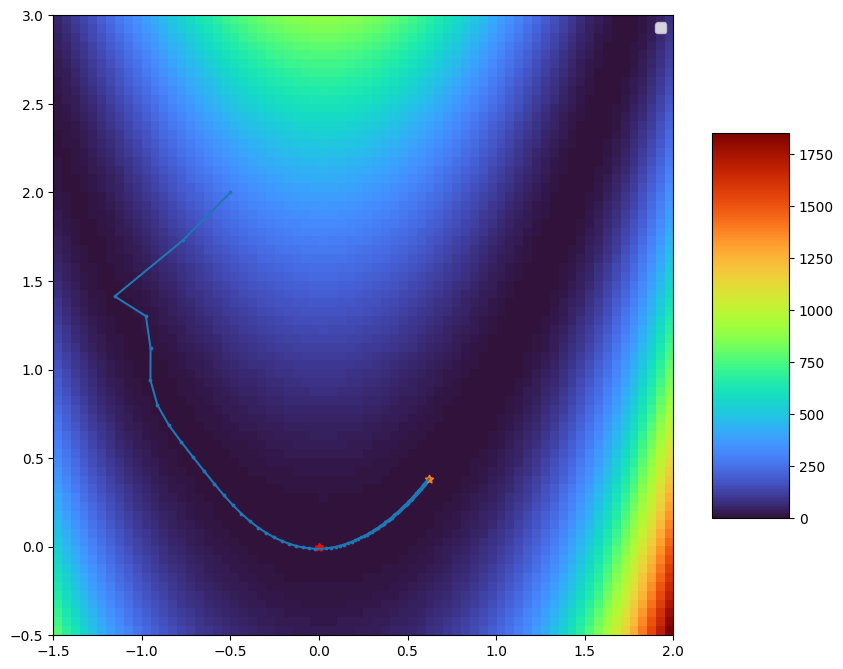

In [148]:
plot_best_solution()

In [131]:
best_alpha = hyperparameter_optimization()

100%|██████████| 10/10 [00:00<00:00, 407.69it/s]


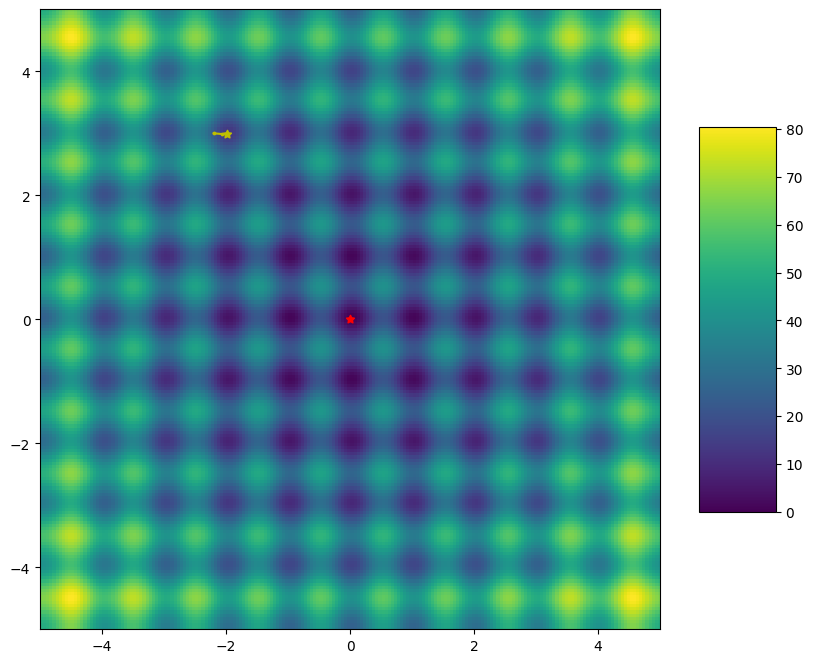

In [31]:
optimizer = GradientOptimizer(
    Rastrigin_function, 
    Rastrigin_gradient, 
    alpha=best_alpha, 
    beta=best_beta,
    method='momentum',
)
x_seq, y_seq = optimizer.find_minimum(x_0)
x_star = np.array([0, 0])
solution_visualization(Rastrigin_function, x_seq, x_star)